                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-02-07 12:00:30.000000512     240.559452     167.187516   
min              2021-08-09 00:01:00     -12.900000      -7.800000   
25%              2021-11-08 06:00:45      -2.000000      -0.500000   
50%              2022-02-07 12:00:30       1.800000      -0.100000   
75%              2022-05-09 18:00:15     483.400000     314.200000   
max              2022-08-09 00:00:00    1413.000000     952.300000   
std                              NaN     331.131327     261.710501   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      115.358961     236.589496     228.883576      28.179683   
min       -12.600000       0.000000       0.000000      11.000000   
25%        -2.100000       0.000000       0.000000      24.200000   
50%         1.600000    

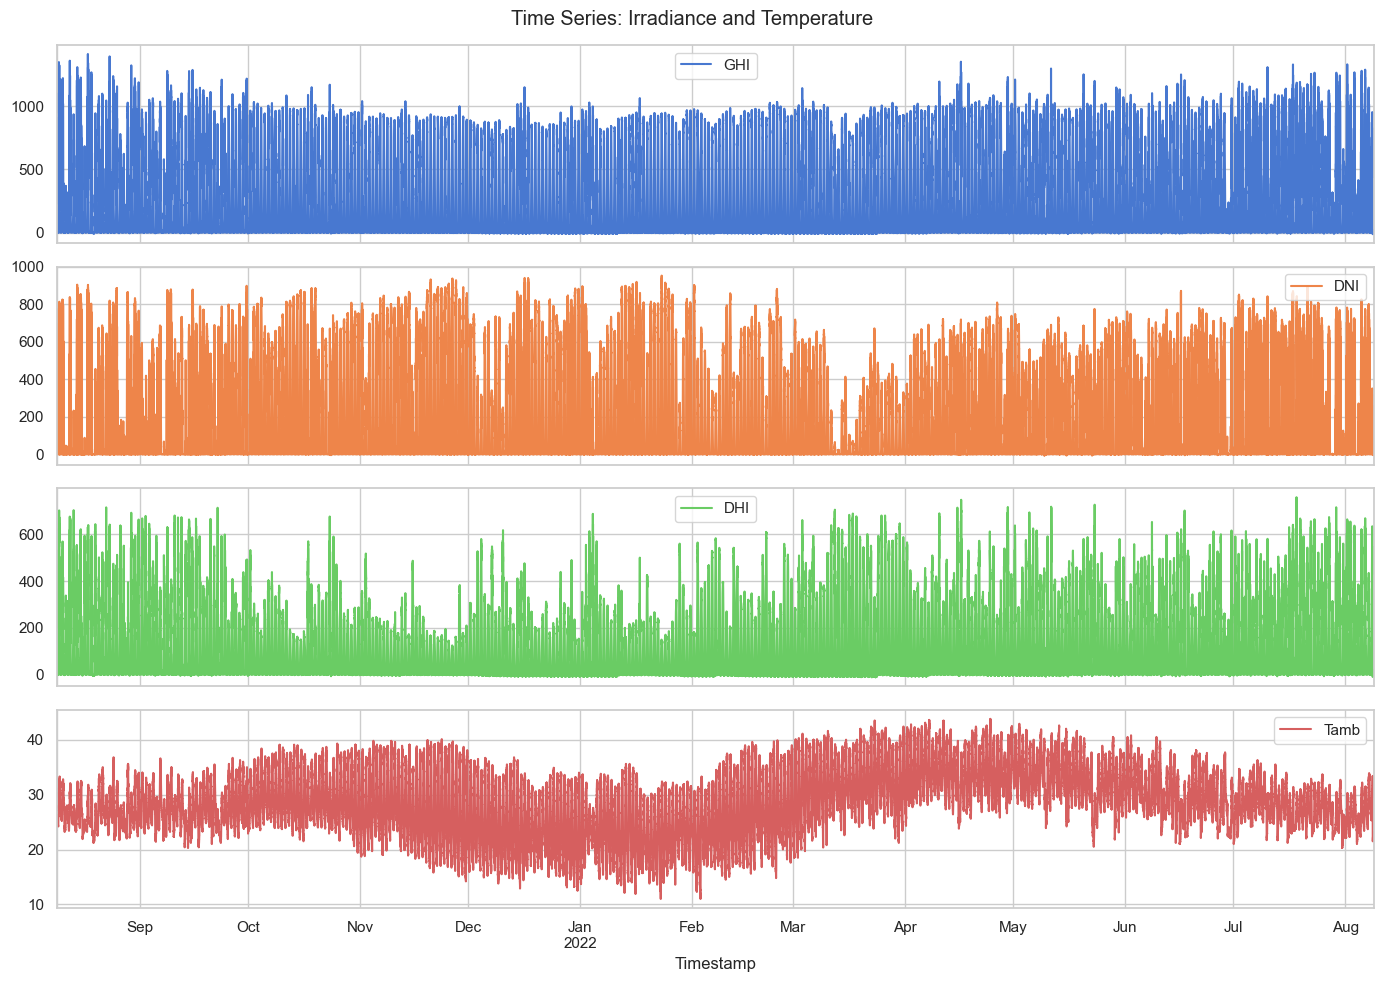

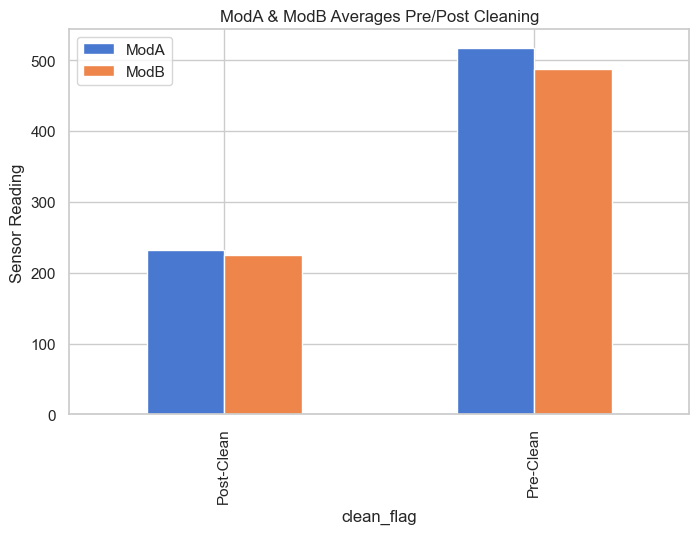

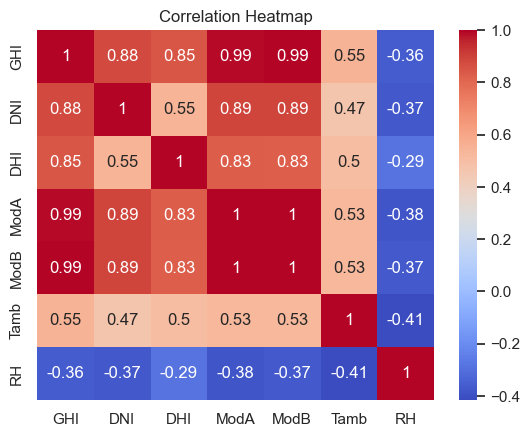

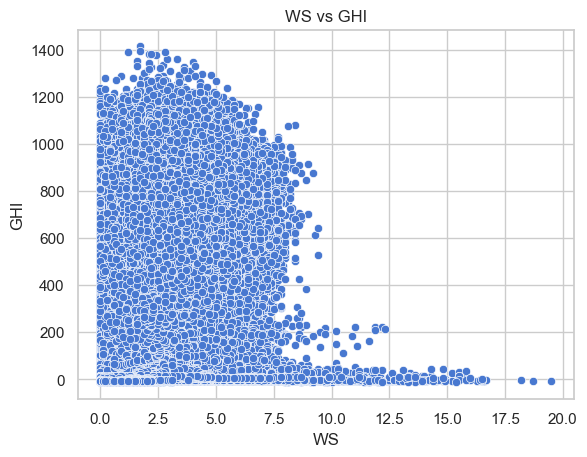

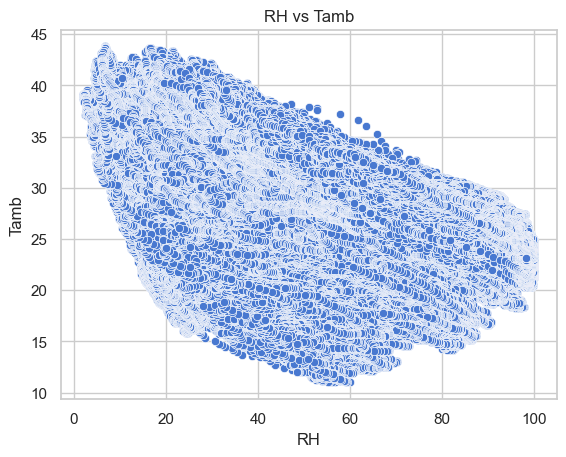

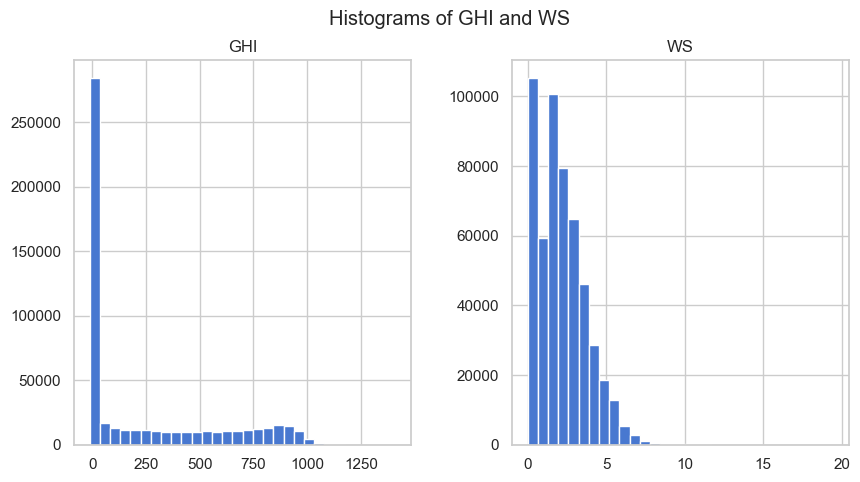

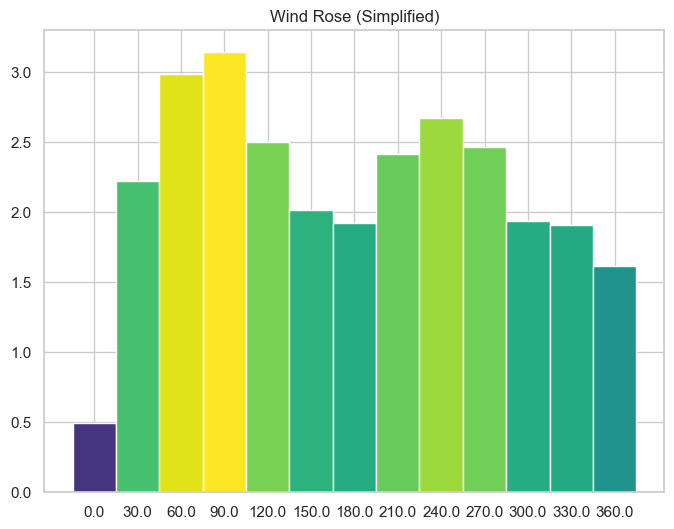

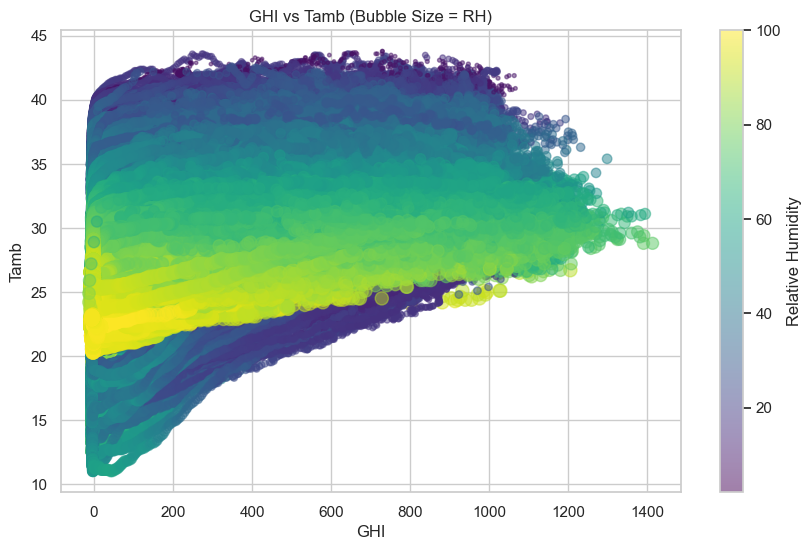

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='muted')

# Load data
df = pd.read_csv('data/benin-malanville.csv', parse_dates=['Timestamp'])

# Preview
df.head()


# Summary statistics
summary_stats = df.describe()
print(summary_stats)

# Missing value count and percentage
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_report = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
missing_report = missing_report[missing_report['Percent'] > 5]
missing_report


cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[cols_to_check].apply(zscore)

# Flag outliers
outliers = (z_scores.abs() > 3)
df['is_outlier'] = outliers.any(axis=1)

# Show number of outliers
df['is_outlier'].value_counts()


# Impute missing values in key columns with median
for col in cols_to_check:
    df[col] = df[col].fillna(df[col].median())

# Export cleaned data
df_clean = df.drop(columns=['is_outlier'])  # Optional
df_clean.to_csv('data/benin_clean.csv', index=False)


time_cols = ['GHI', 'DNI', 'DHI', 'Tamb']
df.set_index('Timestamp')[time_cols].plot(subplots=True, figsize=(14, 10), title='Time Series: Irradiance and Temperature')
plt.tight_layout()
plt.show()


# Add "Cleaned" flag before/after imputation if needed
df['clean_flag'] = df['is_outlier'].apply(lambda x: 'Post-Clean' if not x else 'Pre-Clean')

# Compare mean ModA & ModB
df.groupby('clean_flag')[['ModA', 'ModB']].mean().plot(kind='bar', figsize=(8, 5))
plt.title("ModA & ModB Averages Pre/Post Cleaning")
plt.ylabel("Sensor Reading")
plt.show()


# Heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
sns.scatterplot(x='WS', y='GHI', data=df)
plt.title("WS vs GHI")
plt.show()

sns.scatterplot(x='RH', y='Tamb', data=df)
plt.title("RH vs Tamb")
plt.show()


# Histogram
df[['GHI', 'WS']].hist(bins=30, figsize=(10, 5))
plt.suptitle("Histograms of GHI and WS")
plt.show()

# Wind rose (approximate using polar bar plot)
import matplotlib.cm as cm
wind = df[['WS', 'WD']].dropna()
wind['Direction_bin'] = (wind['WD'] // 30) * 30
rose_data = wind.groupby('Direction_bin')['WS'].mean()

plt.figure(figsize=(8, 6))
angles = np.deg2rad(rose_data.index)
bars = plt.bar(angles, rose_data.values, width=np.deg2rad(30), color=cm.viridis(rose_data.values / max(rose_data.values)))
plt.title("Wind Rose (Simplified)")
plt.xticks(ticks=angles, labels=rose_data.index)
plt.show()


# Bubble chart: GHI vs Tamb, bubble = RH
plt.figure(figsize=(10, 6))
bubble = plt.scatter(df['GHI'], df['Tamb'], s=df['RH'], alpha=0.5, c=df['RH'], cmap='viridis')
plt.colorbar(bubble, label='Relative Humidity')
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs Tamb (Bubble Size = RH)')
plt.show()
